In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import EarlyStopping
from pmdarima.utils import diff_inv
import statsmodels.api as sm
import statsmodels
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential,load_model,Model
from statsmodels.tsa.arima_process import arma_generate_sample
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K
from collections import defaultdict,Counter

import warnings
warnings.filterwarnings("ignore")
np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [12]:
def acc_cal(test,true):
    assert test.shape==true.shape
    cnt=0
    length=true.shape[-1]
    for x,y in zip(test,true):
        if sum(x==y)==length:
            cnt+=1
    return cnt/true.shape[0]

def to_put(array,timesteps):
    array=array[:,:timesteps]
    array=array.reshape((array.shape[0],array.shape[1],1))
    return array

In [13]:
# table은 기본적으로 binary classification 기준
def  table_acc(model,input_set,output_set,adf_set):
        result={}
        classifier_acc=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_acc.append(np.round(model.evaluate(to_put(inputs,100),outputs)[1],3))
        result['model']=classifier_acc

        acc_adf1=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf1.append(acc_cal(adf['1%']['bi'],outputs))
        result['adf_1%']=acc_adf1
        acc_adf5=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf5.append(acc_cal(adf['5%']['bi'],outputs))
        result['adf_5%']=acc_adf5
        acc_adf10=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf10.append(acc_cal(adf['10%']['bi'],outputs))
        result['adf_10%']=acc_adf10
        return result
## multi acc
def  table_accm(model,input_set,output_set,adf_set):
        result={}
        classifier_acc=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_acc.append(np.round(model.evaluate(to_put(inputs,100),outputs)[1],3))
        result['model']=classifier_acc
        acc_adf1=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf1.append(acc_cal(adf['1%']['multi'],outputs))
        result['adf_1%']=acc_adf1    
        acc_adf5=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf5.append(acc_cal(adf['5%']['multi'],outputs))
        result['adf_5%']=acc_adf5
        acc_adf10=[]
        for adf,outputs in zip(adf_set,output_set):
            acc_adf10.append(acc_cal(adf['10%']['multi'],outputs))
        result['adf_10%']=acc_adf10        
        return result

In [35]:
def  table_size(model,input_set,output_set,adf_set):
        result={}
        classifier_size=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_size.append(model_size(model,inputs,outputs))
        result['model']=classifier_size
        size_adf1=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf1.append(adf_size(adf,inputs,outputs,'1%'))
        result['adf_1%']=size_adf1
        size_adf5=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf5.append(adf_size(adf,inputs,outputs,'5%'))
        result['adf_5%']=size_adf5
        size_adf10=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            size_adf10.append(adf_size(adf,inputs,outputs,'10%'))
        result['adf_10%']=size_adf10
        return result
def adf_size(adf,inputs,outputs,sig):
    in0,out0,idx0=sort_H0(inputs,outputs)
    size=np.round(np.sum(adf[sig]['bi'][idx0],axis=0)[1]/len(idx0),3)
    return size

In [34]:
def  table_power(model,input_set,output_set,adf_set):
        result={}
        classifier_power=[]
        for inputs,outputs in zip(input_set,output_set):
            classifier_power.append(model_power(model,inputs,outputs))
        result['model']=classifier_power

        power_adf1=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            power_adf1.append(adf_power(adf,inputs,outputs,'1%'))
        result['adf_1%']=power_adf1
        
        power_adf5=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            power_adf5.append(adf_power(adf,inputs,outputs,'5%'))
        result['adf_5%']=power_adf5
        
        power_adf10=[]
        for adf,inputs,outputs in zip(adf_set,input_set,output_set):
            power_adf10.append(adf_power(adf,inputs,outputs,'10%'))
        result['adf_10%']=power_adf10
        return result

In [14]:
def model_size(model,inputs,outputs):
    in0,out0,idx0=sort_H0(inputs,outputs)
    size=np.round(np.sum(np.round(model.predict(to_put(in0,100))),axis=0)[1]/len(idx0),3)
    return size
def adf_size(adf,inputs,outputs,sig):
    in0,out0,idx0=sort_H0(inputs,outputs)
    size=np.round(np.sum(adf[sig]['bi'][idx0],axis=0)[1]/len(idx0),3)
    return size
def model_power(model,inputs,outputs):
    in1,out1,idx1=sort_H1(inputs,outputs)
    power=np.round(np.sum(np.round(model.predict(to_put(in1,100))),axis=0)[1]/len(idx1),3)
    return power
def adf_power(adf,inputs,outputs,sig):
    in1,out1,idx1=sort_H1(inputs,outputs)
    power=np.round(np.sum(adf[sig]['bi'][idx1],axis=0)[1]/len(idx1),3)
    return power

In [16]:
def adf_rtest(array): #두 번의 adf test에서 같은 significance level 사용/sig=0 => 1%/ sig=1=>5%/sig=2 => 10%
    array=array[:,:100] # 
    assert array.shape[1]
    adf_test_result={}
    critical_value=sm.tsa.adfuller(array[0,:100],regression='n')[4]
#    critical_value={'1%':-2.33,'5%':-1.65,'10%':-1.28}
    for sig_level in ['1%','5%','10%']: # critical value at sig.level 1%,5%,10% each
        dic=defaultdict(np.array)
        bi=[]
        multi=[]
        for i in range(0,array.shape[0]):
            test_result=sm.tsa.adfuller(array[i],regression='n')
            tval=test_result[0]
            c_value=critical_value[sig_level]
            if tval>=c_value:
                bi.append([1,0])
                tval_diff=sm.tsa.adfuller(np.diff(array[i]),regression='n')[0]
                if tval_diff>=c_value:
                    multi.append([1,0,0]) ## diff order 2
                else:
                    multi.append([0,1,0]) ## diff order 1
            else:
                bi.append([0,1])
                multi.append([0,0,1])
        dic['bi']=np.array(bi)
        dic['multi']=np.array(multi)
        #
        adf_test_result[sig_level]=dic
    return adf_test_result

In [37]:
def sort_H1(inputs,outputs): # sorting unit root series for calculating empirical size
    inputs_sorted=[]
    outputs_sorted=[]
    indices=[]
    for i,x,y in zip(range(len(inputs)),inputs,outputs):
        if y[-1]==1:
            inputs_sorted.append(x)
            outputs_sorted.append(y)
            indices.append(i)
    inputs_sorted=np.array(inputs_sorted)
    outputs_sorted=np.array(outputs_sorted)
    return inputs_sorted,outputs_sorted,indices
def sort_H0(inputs,outputs): # sorting unit root series for calculating empirical size
    inputs_sorted=[]
    outputs_sorted=[]
    indices=[]
    for i,x,y in zip(range(len(inputs)),inputs,outputs):
        if y[-1]==0:
            inputs_sorted.append(x)
            outputs_sorted.append(y)
            indices.append(i)
    inputs_sorted=np.array(inputs_sorted)
    outputs_sorted=np.array(outputs_sorted)
    return inputs_sorted,outputs_sorted,indices

## load training dataset

In [24]:
fdin=pd.read_csv('c:/data/dataset/fdin.csv',header=None).to_numpy()
fdoutb=pd.read_csv('c:/data/dataset/fdoutb.csv',header=None).to_numpy()
fdoutm=pd.read_csv('c:/data/dataset/fdoutm.csv',header=None).to_numpy()
#
trin=fdin[:100000]
valin=fdin[100000:130000]
tein=fdin[130000:]
#
troutb=fdoutb[:100000]
valoutb=fdoutb[100000:130000]
teoutb=fdoutb[130000:]
#
troutm=fdoutm[:100000]
valoutm=fdoutm[100000:130000]
teoutm=fdoutm[130000:]

## load combine dataset

In [18]:
def split_set(interval,dataset):
    split_dataset=[dataset[interval*i:interval*(i+1)] for i in range(6)]
    return split_dataset
cin=pd.read_csv('c:/data/dataset/cin.csv',header=None).to_numpy()
coutb=pd.read_csv('c:/data/dataset/coutb.csv',header=None).to_numpy()
coutm=pd.read_csv('c:/data/dataset/coutm.csv',header=None).to_numpy()
#
cin=split_set(10000,cin)
coutb=split_set(10000,coutb)
coutm=split_set(10000,coutm)
# dataset composed of  10000 samples of each p=0.15,0.3,0.45,0.6.0.75,0.9

### load trained binary classifier

In [21]:
dbL=load_model('c:/data/final/dbL.hdf5') # binary classification model for unit root test

### load ADF test result

In [30]:
rd_adf=np.load('c:/data/final/rd_adf.npy',allow_pickle=True).item()

In [38]:
print(table_acc(dbL,[tein],[teoutb],[rd_adf]))
print(table_size(dbL,[tein],[teoutb],[rd_adf]))
print(table_power(dbL,[tein],[teoutb],[rd_adf]))

313/313 [==============================] - 1s 4ms/step - loss: 0.0415 - accuracy: 0.9824
{'model': [0.982], 'adf_1%': [0.9505], 'adf_5%': [0.9458], 'adf_10%': [0.9288]}
157/157 [==============================] - 1s 2ms/step
{'model': [0.018], 'adf_1%': [0.021], 'adf_5%': [0.068], 'adf_10%': [0.117]}
157/157 [==============================] - 0s 2ms/step
{'model': [0.983], 'adf_1%': [0.922], 'adf_5%': [0.96], 'adf_10%': [0.974]}


### Table 3.1

In [41]:
pd.DataFrame({'Classifier_LSTM':[.982,.018,0.983],'ADF_1%':[.951,.021,.922],'ADF_5%':[.9458,.068,.960],'ADF_10%':[.929,.117,.974]},index=['acc','size','power'])

,Classifier_LSTM,ADF_1%,ADF_5%,ADF_10%
acc,0.982,0.951,0.9458,0.929
size,0.018,0.021,0.0680,0.117
power,0.983,0.922,0.9600,0.974


### load ADF test result of combined testset

In [46]:
c1_adf=np.load('c:/data/final/c1_adf.npy',allow_pickle=True).item()
c2_adf=np.load('c:/data/final/c2_adf.npy',allow_pickle=True).item()
c3_adf=np.load('c:/data/final/c3_adf.npy',allow_pickle=True).item()
c4_adf=np.load('c:/data/final/c4_adf.npy',allow_pickle=True).item()
c5_adf=np.load('c:/data/final/c5_adf.npy',allow_pickle=True).item()
c6_adf=np.load('c:/data/final/c6_adf.npy',allow_pickle=True).item()
c_adf=[c1_adf,c2_adf,c3_adf,c4_adf,c5_adf,c6_adf]

### load trained model- 3 class classifier

In [47]:
t4_1=table_acc(dbL,cin,coutb,c_adf)
t4_1

313/313 [==============================] - 1s 4ms/step - loss: 0.1454 - accuracy: 0.9556


{'model': [0.978, 0.974, 0.971, 0.964, 0.959, 0.956],
 'adf_1%': [0.9222, 0.9266, 0.9316, 0.9371, 0.9413, 0.9494],
 'adf_5%': [0.9483, 0.9395, 0.9317, 0.9203, 0.9099, 0.905],
 'adf_10%': [0.9524, 0.9339, 0.9193, 0.8984, 0.8764, 0.8668]}

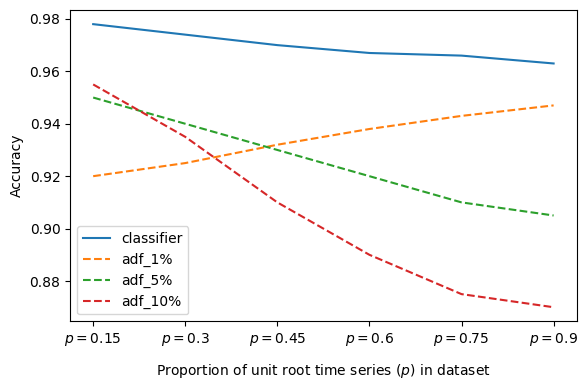

In [48]:
#import matplotlib.pyplot as plt

# x축 값과 y축 값 재설정 (이미지 재생성 목적)
x_vals = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
classifier = [0.978, 0.974, 0.970, 0.967, 0.966, 0.963]
adf_1 = [0.920, 0.925, 0.932, 0.938, 0.943, 0.947]
adf_5 = [0.950, 0.940, 0.930, 0.920, 0.910, 0.905]
adf_10 = [0.955, 0.935, 0.910, 0.890, 0.875, 0.870]

# 새로운 plot 생성
plt.figure(figsize=(6, 4))
plt.plot(x_vals, classifier, label='classifier')
plt.plot(x_vals, adf_1, label='adf_1%', linestyle='--')
plt.plot(x_vals, adf_5, label='adf_5%', linestyle='--')
plt.plot(x_vals, adf_10, label='adf_10%', linestyle='--')

plt.xlabel(r'Proportion of unit root time series ($p$) in dataset', labelpad=10)
plt.ylabel('Accuracy')
plt.xticks(x_vals, [r'$p=0.15$', r'$p=0.3$', r'$p=0.45$', r'$p=0.6$', r'$p=0.75$', r'$p=0.9$'])
plt.legend()
plt.tight_layout()
#plt.savefig('plzzzz.png',dpi=300)

### load trained 3-class classifier

In [50]:
dmL=load_model('c:/data/final/dmL.hdf5')

In [53]:
print(table_accm(dmL,[tein],[teoutm],[rd_adf]))

313/313 [==============================] - 2s 4ms/step - loss: 0.1043 - accuracy: 0.9595
{'model': [0.96], 'adf_1%': [0.9269], 'adf_5%': [0.9211], 'adf_10%': [0.8972]}


### comparison between 3-class classifier and ADF test

In [54]:
pd.DataFrame({'Classifier_LSTM':[.96],'ADF_1%':[.927],'ADF_5%':[.921],'ADF_10%':[.897]},index=['acc'])

,Classifier_LSTM,ADF_1%,ADF_5%,ADF_10%
acc,0.96,0.927,0.921,0.897


In [51]:
##lur0,ur1,ur2  순서
minn=pd.read_csv('c:/data/dataset/minn.csv',header=None).to_numpy()
moutb=pd.read_csv('c:/data/dataset/moutb.csv',header=None).to_numpy()
moutm=pd.read_csv('c:/data/dataset/moutm.csv',header=None).to_numpy()
m_adf=np.load('c:/data/m_adf.npy',allow_pickle=True).item() #

In [52]:
print(np.sum(np.round(dmL.predict(to_put(minn[:10000],100))),axis=0)) # ur0
print(np.sum(np.round(dmL.predict(to_put(minn[10000:20000],100))),axis=0)) # ur1
print(np.sum(np.round(dmL.predict(to_put(minn[20000:],100))),axis=0)) # ur2

313/313 [==============================] - 1s 3ms/step
[   0.  191. 9809.]
313/313 [==============================] - 1s 2ms/step
[ 582. 9052.  366.]
313/313 [==============================] - 1s 2ms/step
[9749.  251.    0.]


## plot

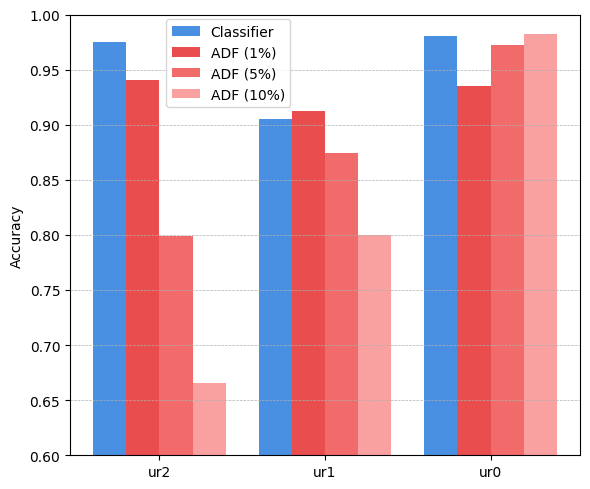

In [27]:
classes = ['ur2', 'ur1', 'ur0']
classifier_acc = [9749/10000,9052/10000,9809/10000]
# ur2,ur1,ur0순
adf_1 = [0.9402, 0.9124, 0.935]
adf_5 = [0.7989, 0.8744, 0.9723]
adf_10 = [0.6658, 0.7999, 0.9819]

x = range(len(classes))
width = 0.2  # 막대 너비

# 그래프 생성
plt.figure(figsize=(6, 5))
plt.bar([i - 1.5*width for i in x], classifier_acc, width=width, label='Classifier', color='#4a90e2')   # 파랑
plt.bar([i - 0.5*width for i in x], adf_1, width=width, label='ADF (1%)', color='#e94d4d')              # 진한 빨강
plt.bar([i + 0.5*width for i in x], adf_5, width=width, label='ADF (5%)', color='#f26b6b')              # 중간 빨강
plt.bar([i + 1.5*width for i in x], adf_10, width=width, label='ADF (10%)', color='#f9a1a1')            # 연한 빨강

plt.xticks(x, classes)
plt.ylim(0.6, 1.0)
plt.ylabel('Accuracy')
#plt.title('Class-wise Accuracy Comparison')
plt.legend(loc='center left', bbox_to_anchor=(0.175,0.89))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('barchartf.png')
plt.show()

- barchart. ur2 class에서 LSTM classifier와 ADF검정간의 성능 차이가 두드러짐.
- ADF 검정은 유의 수준에 따라, 시계열의 단위근 갯수에 따라 큰 성능 차이를 보임.
- 그에 반해 LSTM classifier는 상대적으로 안정적인 성능을 보임.

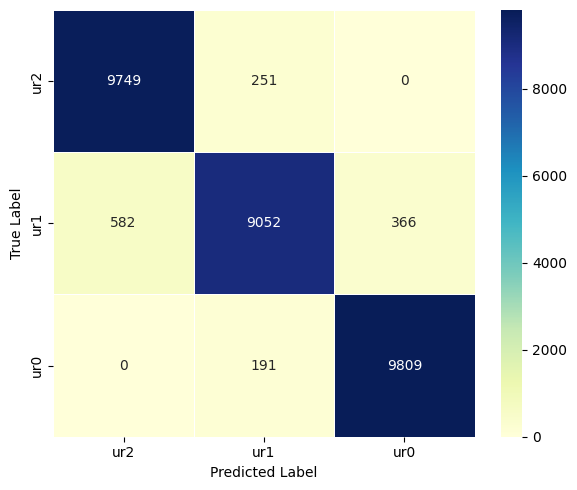

In [28]:
conf_matrix = np.array([
    [9749,251 ,0 ],
    [582,9052 ,366 ],
    [0,191 ,9809 ]
])
classes = ['ur2', 'ur1', 'ur0']
# 그림 저장
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,
            xticklabels=classes, yticklabels=classes, cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.title("Confusion Matrix -Heatmap")
plt.tight_layout()
plt.savefig('conf.png')

- ur2,ur0 class에서 높은 분류 성능을 보임.
- 단위근 시계열인 ur2,ur1클래스만 봤을 때, 시계열에 단위근이 존재하면 높은 확률로 단위근을 인지하는 걸 알 수 있음.
- 다만 ur1을 ur2로 잘못 판단하는 경향이 있는 것으로 보아, classifier는 시계열의 비정상성을 본래보다 다소 강하게 인식하는 것으로 보임.